# SageMaker Training Job 訓練 Ultralytics YOLO11（YOLOv11）

此 Notebook 會：
1. 生成訓練程式 `train.py` 與 `requirements.txt`
2. 以 **SageMaker PyTorch Estimator** 啟動 Training Job
3. 在 Notebook 內**串流顯示訓練日誌**，並**嘗試動態解析每個 epoch 指標，畫出收斂曲線**
4. 訓練完成後下載 artifacts（含 `best.pt`、`runs/`、`results.csv`、`results.png`）並顯示完整曲線

> 注意：動態曲線解析依賴 Ultralytics 日誌格式；若版本輸出不同，可能解析不到，但**訓練完成後**一定能用 `results.csv/results.png` 畫出完整收斂曲線。


## 0) 先決條件

- 已在 SageMaker Studio / Notebook Instance 執行
- IAM role 具備 SageMaker 與 S3 權限
- 你已把 YOLO 格式資料集打包成 zip 放在 S3

資料 zip 內部建議結構：
```
mydata/
  images/train
  images/val
  labels/train
  labels/val
```


In [1]:
import os, json, tarfile, re, time
from pathlib import Path

import boto3
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.inputs import TrainingInput
from sagemaker.s3 import S3Downloader

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Image

sess = sagemaker.Session()
region = sess.boto_region_name
role = sagemaker.get_execution_role()
sm = boto3.client('sagemaker', region_name=region)
logs = boto3.client('logs', region_name=region)

print('region:', region)
print('default bucket:', sess.default_bucket())


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Matplotlib is building the font cache; this may take a moment.


region: us-east-1
default bucket: sagemaker-us-east-1-049281306005


## 1) 參數設定（請改成你的 S3 路徑與類別名稱）

In [4]:
# ====== 你要改的地方 ======
S3_DATA_ZIP = 's3://teach2025/datasets/yolo_test_dataset.zip'  # <<<<<< 改成你的資料集
DATA_ZIP_FILENAME = 'yolo_test_dataset.zip'                     # zip 檔名

# 類別名稱（請改成你的 classes）
CLASS_NAMES = ['class0', 'class1']

# YOLO11 權重（可改 yolo11s.pt / yolo11m.pt / yolo11l.pt / yolo11x.pt）
YOLO_MODEL = 'yolo11n.pt'

# 訓練超參數
EPOCHS = 50
IMGSZ = 640
BATCH = 16
WORKERS = 4

# 訓練硬體（推薦 GPU：g5 / g4dn）
INSTANCE_TYPE = 'ml.g5.2xlarge'
INSTANCE_COUNT = 1

# 輸出到 S3
OUTPUT_S3 = f"s3://teach2025/yolo11/output/"

print('S3_DATA_ZIP:', S3_DATA_ZIP)
print('OUTPUT_S3:', OUTPUT_S3)


S3_DATA_ZIP: s3://teach2025/datasets/yolo_test_dataset.zip
OUTPUT_S3: s3://teach2025/yolo11/output/


## 2) 生成訓練程式碼（train.py）與 requirements.txt

重點：
- SageMaker 會把 `training` channel 掛載在 `/opt/ml/input/data/training/`
- 你要把 artifacts 寫到 `/opt/ml/model/`，SageMaker 才會上傳到 `output_path`
- 我們把 Ultralytics 的 `runs/` 放到 `/opt/ml/model/runs/`，方便事後下載 `results.csv` / `results.png`


In [13]:
src_dir = Path('src')
src_dir.mkdir(exist_ok=True)

train_py = r'''
import argparse
import base64
import json
import zipfile
import shutil
from pathlib import Path
import yaml
from ultralytics import YOLO

def main():
    p = argparse.ArgumentParser()
    p.add_argument('--data_zip', type=str, default='mydata.zip')
    p.add_argument('--model', type=str, default='yolo11n.pt')
    p.add_argument('--epochs', type=int, default=50)
    p.add_argument('--imgsz', type=int, default=640)
    p.add_argument('--batch', type=int, default=16)
    p.add_argument('--workers', type=int, default=4)

    # ✅ 改成 base64，避免 argv 被拆
    p.add_argument('--class_names_b64', type=str, required=True)

    args = p.parse_args()

    # ✅ 解碼回 list[str]
    class_names = json.loads(base64.b64decode(args.class_names_b64).decode("utf-8"))

    sm_data_dir = Path('/opt/ml/input/data/training')
    sm_model_dir = Path('/opt/ml/model')
    sm_model_dir.mkdir(parents=True, exist_ok=True)

    work_dir = Path('/tmp/data')
    work_dir.mkdir(parents=True, exist_ok=True)

    zip_path = sm_data_dir / args.data_zip
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(work_dir)

    entries = [d for d in work_dir.iterdir() if d.is_dir()]
    dataset_root = entries[0] if entries else work_dir

    data_yaml = {
        'path': str(dataset_root),
        'train': str(dataset_root / 'images/train'),
        'val': str(dataset_root / 'images/val'),
        'names': class_names,
    }
    yaml_path = work_dir / 'data.yaml'
    with open(yaml_path, 'w') as f:
        yaml.safe_dump(data_yaml, f)

    model = YOLO(args.model)
    project_dir = sm_model_dir / 'runs'
    model.train(
        data=str(yaml_path),
        epochs=args.epochs,
        imgsz=args.imgsz,
        batch=args.batch,
        workers=args.workers,
        project=str(project_dir),
        name='train',
        verbose=True,
    )

    best_pt = project_dir / 'train' / 'weights' / 'best.pt'
    if best_pt.exists():
        shutil.copy2(best_pt, sm_model_dir / 'best.pt')

if __name__ == '__main__':
    main()

'''

(src_dir / 'train.py').write_text(train_py, encoding='utf-8')
(src_dir / 'requirements.txt').write_text('ultralytics\nopencv-python\npyyaml\n', encoding='utf-8')
print('Wrote:', src_dir / 'train.py')
print('Wrote:', src_dir / 'requirements.txt')


Wrote: src/train.py
Wrote: src/requirements.txt


## 3) 建立 Estimator 並啟動 Training Job（非阻塞）

In [14]:
import base64, json

class_names_b64 = base64.b64encode(
    json.dumps(CLASS_NAMES, ensure_ascii=False).encode("utf-8")
).decode("ascii")

hyperparameters = {
    "data_zip": DATA_ZIP_FILENAME,
    "model": YOLO_MODEL,
    "epochs": EPOCHS,
    "imgsz": IMGSZ,
    "batch": BATCH,
    "workers": WORKERS,
    "class_names_b64": class_names_b64,
}

est = PyTorch(
    entry_point='train.py',
    source_dir=str(src_dir),
    role=role,
    framework_version='2.2',
    py_version='py310',
    instance_count=INSTANCE_COUNT,
    instance_type=INSTANCE_TYPE,
    hyperparameters=hyperparameters,
    output_path=OUTPUT_S3,
)

job_name = f"yolo11-train-{int(time.time())}"
print('TrainingJobName:', job_name)

est.fit(
    inputs={'training': TrainingInput(S3_DATA_ZIP, content_type='application/zip')},
    job_name=job_name,
    wait=False,
)
print('已送出 Training Job。接著跑下一格開始動態監控。')


INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: yolo11-train-1766208611


TrainingJobName: yolo11-train-1766208611
已送出 Training Job。接著跑下一格開始動態監控。


## 4) 動態顯示訓練過程與收斂曲線（即時）

會從 CloudWatch Logs 拉取最新日誌並嘗試解析 epoch 指標。


In [15]:
import boto3, re

logs = boto3.client("logs", region_name=region)

def list_sagemaker_log_groups(prefix_hint="/aws/sagemaker"):
    resp = logs.describe_log_groups(logGroupNamePrefix=prefix_hint, limit=50)
    return [g["logGroupName"] for g in resp.get("logGroups", [])]

print("\n".join(list_sagemaker_log_groups()))
desc = sm.describe_training_job(TrainingJobName=job_name)
print("TrainingJobArn =", desc["TrainingJobArn"])


/aws/sagemaker/NotebookInstances
/aws/sagemaker/TrainingJobs
TrainingJobArn = arn:aws:sagemaker:us-east-1:049281306005:training-job/yolo11-train-1766208611


In [17]:
import time
import re
import pandas as pd
import matplotlib.pyplot as plt
import boto3
from IPython.display import display, clear_output

# ------------------------------------------------------------
# 1) 先用原本的 sm 取得 TrainingJobArn，反推出 job 的 region
# ------------------------------------------------------------
desc = sm.describe_training_job(TrainingJobName=job_name)
training_job_arn = desc["TrainingJobArn"]
job_region = training_job_arn.split(":")[3]

print("TrainingJobArn:", training_job_arn)
print("Job region    :", job_region)

# ------------------------------------------------------------
# 2) 用「job 的 region」重新建立 clients（關鍵修正點）
# ------------------------------------------------------------
logs = boto3.client("logs", region_name=job_region)
sm2  = boto3.client("sagemaker", region_name=job_region)

print("CloudWatch logs region =", logs.meta.region_name)
print("SageMaker client region =", sm2.meta.region_name)

# ------------------------------------------------------------
# 3) 重新定義 helper functions（只差在用 sm2 / logs）
# ------------------------------------------------------------
def get_training_job_status(job_name: str):
    d = sm2.describe_training_job(TrainingJobName=job_name)
    return d["TrainingJobStatus"], d

def find_log_stream(job_name: str, log_group="/aws/sagemaker/TrainingJobs"):
    paginator = logs.get_paginator("describe_log_streams")
    for page in paginator.paginate(
        logGroupName=log_group,
        logStreamNamePrefix=job_name
    ):
        streams = page.get("logStreams", [])
        if streams:
            streams = sorted(
                streams,
                key=lambda s: s.get("lastEventTimestamp", 0),
                reverse=True
            )
            return streams[0]["logStreamName"]
    return None

def fetch_logs(log_group, log_stream, next_token=None):
    kwargs = dict(
        logGroupName=log_group,
        logStreamName=log_stream,
        startFromHead=True
    )
    if next_token:
        kwargs["nextToken"] = next_token
    resp = logs.get_log_events(**kwargs)
    return resp.get("events", []), resp.get("nextForwardToken")

# ------------------------------------------------------------
# 4) epoch log best-effort parser（不變）
# ------------------------------------------------------------
epoch_metrics = []
epoch_line_re = re.compile(
    r"^\s*(\d+)\s+([0-9.eE+-]+)\s+([0-9.eE+-]+)\s+([0-9.eE+-]+)\s+([0-9.eE+-]+)\s+([0-9.eE+-]+)"
)

def try_parse_epoch_line(msg: str):
    m = epoch_line_re.match(msg)
    if not m:
        return None
    epoch = int(m.group(1))
    vals = [float(m.group(i)) for i in range(2, 7)]
    return {
        "epoch": epoch,
        "v1": vals[0],
        "v2": vals[1],
        "v3": vals[2],
        "v4": vals[3],
        "v5": vals[4],
    }

# ------------------------------------------------------------
# 5) 找 log stream（現在一定在正確 region）
# ------------------------------------------------------------
log_group = "/aws/sagemaker/TrainingJobs"
log_stream = None
token = None
seen = set()
tail = []

print("尋找 CloudWatch Log Stream...")
for _ in range(60):
    log_stream = find_log_stream(job_name, log_group=log_group)
    if log_stream:
        break
    time.sleep(5)

if not log_stream:
    raise RuntimeError(
        f"找不到 log stream（job_name={job_name}，region={job_region}）"
    )

print("log_group :", log_group)
print("log_stream:", log_stream)

# ------------------------------------------------------------
# 6) 即時監控 + 動態收斂曲線
# ------------------------------------------------------------
while True:
    status, desc = get_training_job_status(job_name)

    events, token = fetch_logs(log_group, log_stream, token)
    new_lines = []

    for e in events:
        key = (e.get("timestamp"), e.get("message"))
        if key in seen:
            continue
        seen.add(key)

        msg = (e.get("message") or "").rstrip("\n")
        if not msg:
            continue

        new_lines.append(msg)

        parsed = try_parse_epoch_line(msg)
        if parsed:
            if not epoch_metrics or parsed["epoch"] != epoch_metrics[-1]["epoch"]:
                epoch_metrics.append(parsed)

    tail = (tail + new_lines)[-50:]

    clear_output(wait=True)
    print("TrainingJob:", job_name)
    print("Status     :", status)
    print("Region     :", job_region)
    print("----- logs tail -----")
    for line in tail:
        print(line)

    if len(epoch_metrics) >= 2:
        df_live = pd.DataFrame(epoch_metrics).sort_values("epoch")
        display(df_live.tail(10))

        plt.figure()
        plt.plot(df_live["epoch"], df_live["v1"], label="v1")
        plt.plot(df_live["epoch"], df_live["v2"], label="v2")
        plt.plot(df_live["epoch"], df_live["v3"], label="v3")
        plt.xlabel("epoch")
        plt.legend()
        plt.title("Live convergence (parsed from CloudWatch logs)")
        plt.show()

    if status in ["Completed", "Failed", "Stopped"]:
        print("\nTraining job finished with status:", status)
        if status != "Completed":
            print("FailureReason:", desc.get("FailureReason"))
        break

    time.sleep(10)


TrainingJob: yolo11-train-1766208611
Status     : Completed
Region     : us-east-1
----- logs tail -----
#033[K                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 23.1it/s 0.0s#015#033[K                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 23.1it/s 0.0s
all          4          4    0.00718          1      0.995      0.995
Closing dataloader mosaic
#033[K      41/50       1.5G     0.4215      2.028     0.9412         10        640: 0% ──────────── 0/1  0.3s
#033[K      41/50       1.5G     0.4215      2.028     0.9412         10        640: 100% ━━━━━━━━━━━━ 1/1 3.4it/s 0.3s
#033[K                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 12.8it/s 0.1s#015#033[K                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 12.8it/s 0.1s
all          4          4    0.007

## 5) 下載 artifacts 並畫出完整收斂曲線（results.csv / results.png）

Final status: Completed
Model artifact: s3://teach2025/yolo11/output/yolo11-train-1766208611/output/model.tar.gz
Downloaded: artifacts/yolo11-train-1766208611/model.tar.gz
best.pt exists: True
results.png exists: True
results.csv exists: True


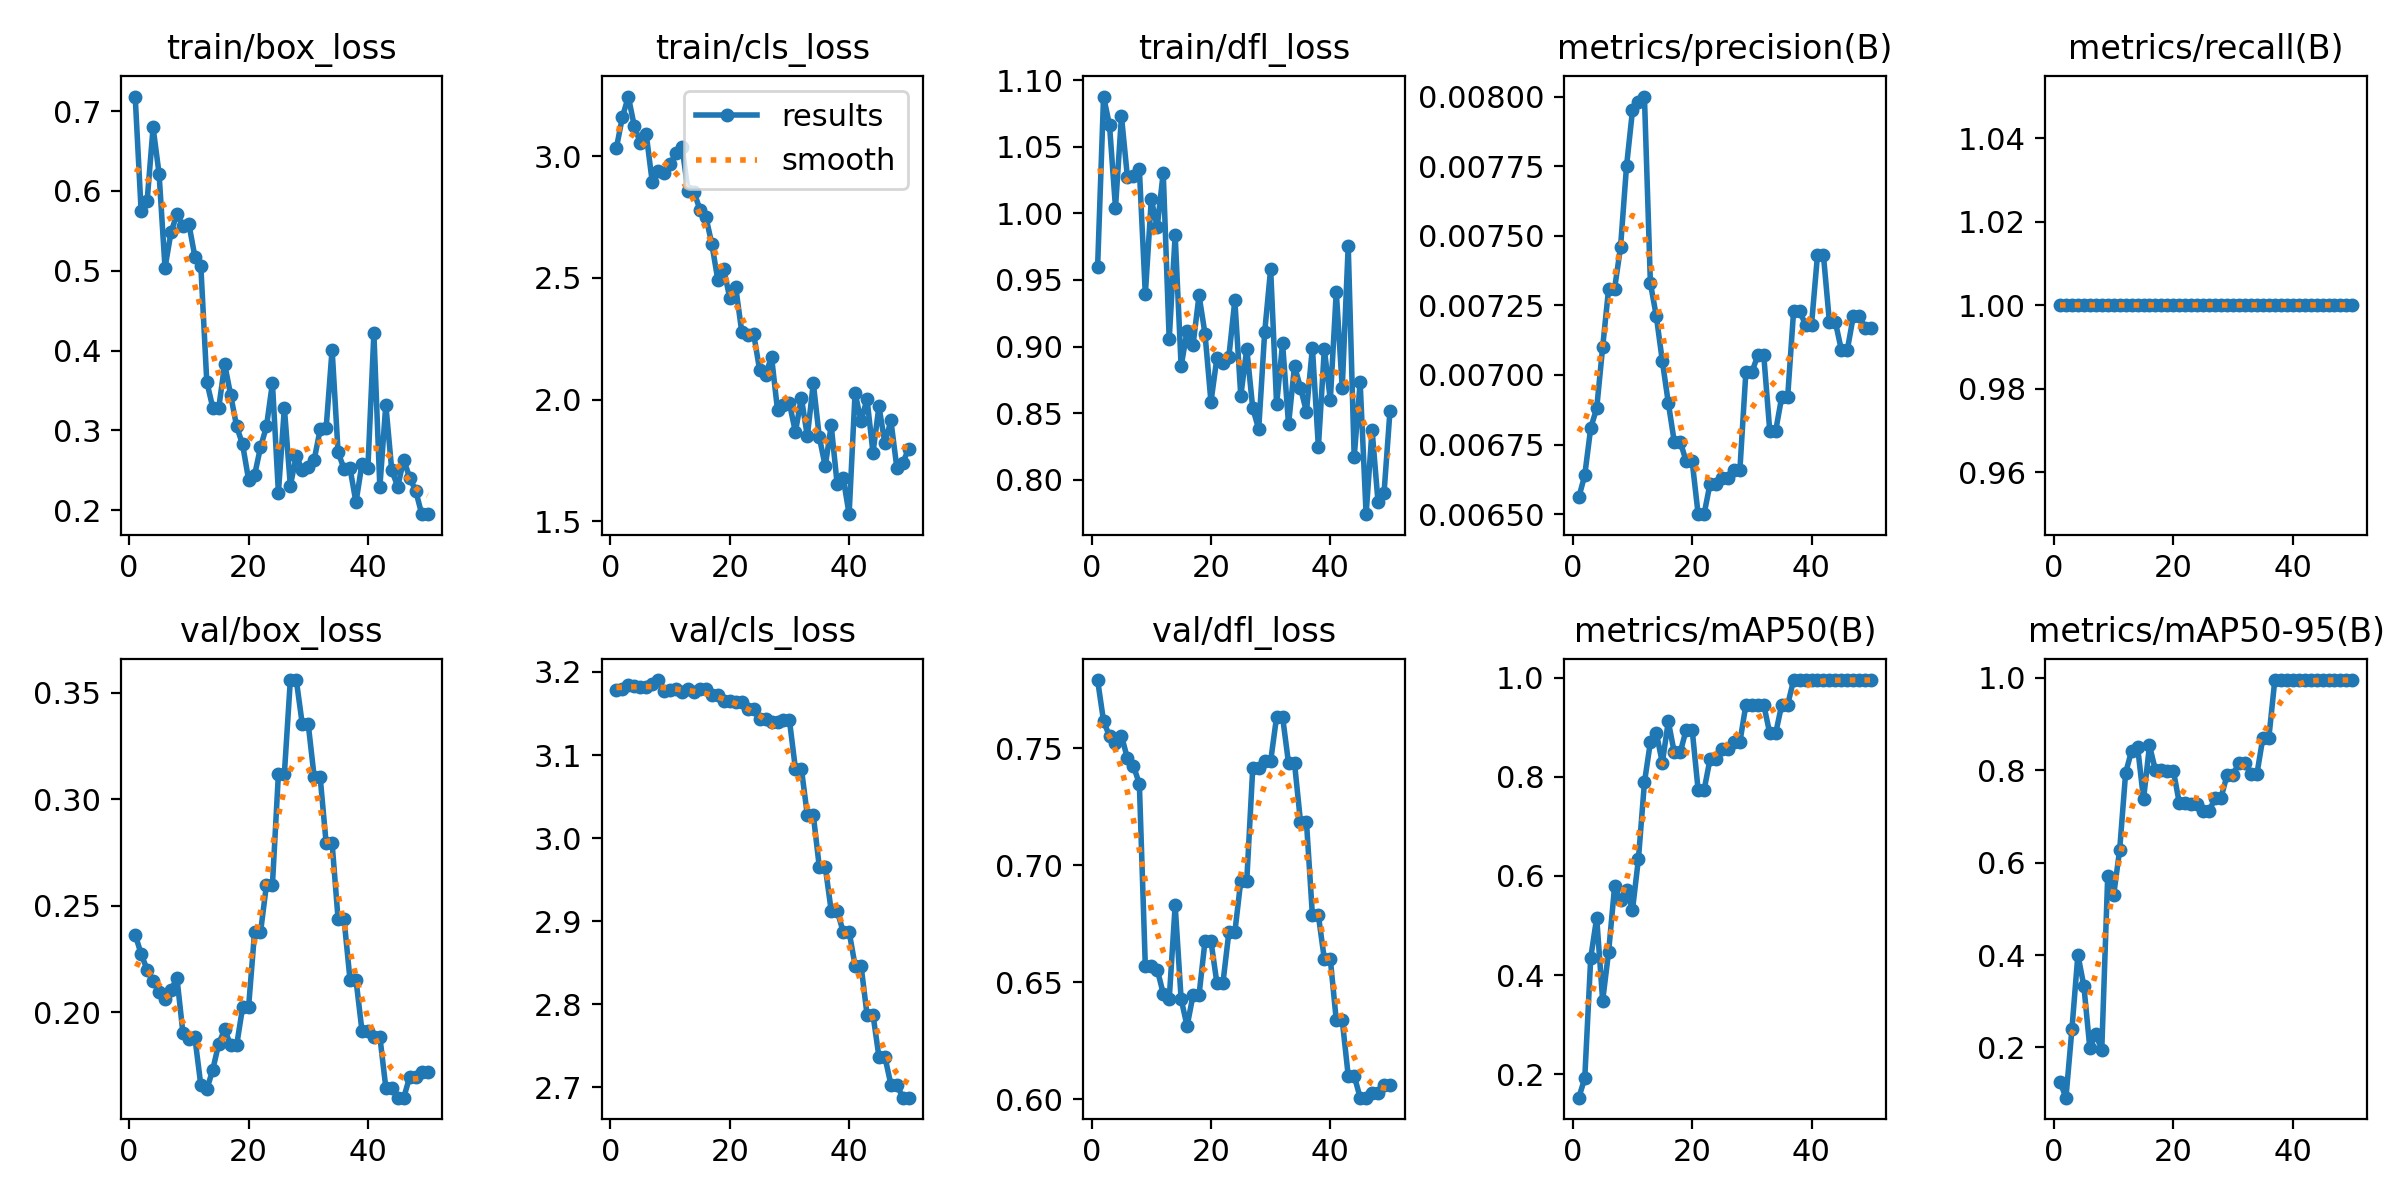

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.71315,0.71812,3.03363,0.95934,0.00656,1,0.15310,0.12574,0.23647,3.17815,0.77904,0.000000,0.000000,0.000000
1,2,2.00035,0.57415,3.15946,1.08765,0.00664,1,0.19201,0.09139,0.22737,3.17986,0.76152,0.000016,0.000016,0.000016
2,3,2.29844,0.58745,3.24487,1.06613,0.00681,1,0.43506,0.23980,0.22008,3.18412,0.75498,0.000032,0.000032,0.000032
3,4,2.57606,0.67937,3.12329,1.00413,0.00688,1,0.51583,0.40062,0.21466,3.18272,0.75195,0.000047,0.000047,0.000047
4,5,2.85650,0.62161,3.05581,1.07279,0.00710,1,0.34867,0.33323,0.20956,3.18241,0.75527,0.000061,0.000061,0.000061


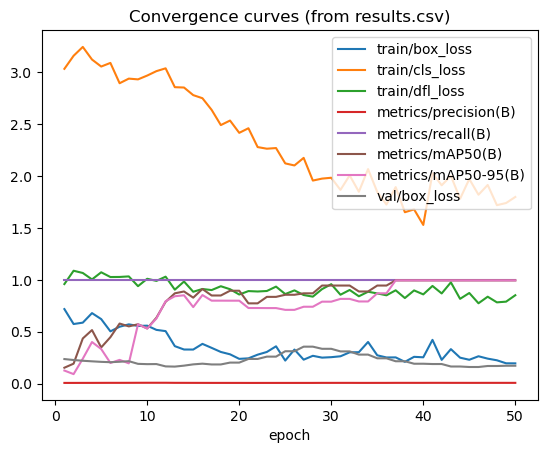

In [18]:
while True:
    status, _ = get_training_job_status(job_name)
    if status in ['Completed', 'Failed', 'Stopped']:
        print('Final status:', status)
        break
    time.sleep(20)

if status != 'Completed':
    raise RuntimeError(f'Training job not completed: {status}')

desc = sm.describe_training_job(TrainingJobName=job_name)
model_artifact = desc['ModelArtifacts']['S3ModelArtifacts']
print('Model artifact:', model_artifact)

out_dir = Path('artifacts') / job_name
out_dir.mkdir(parents=True, exist_ok=True)

S3Downloader.download(model_artifact, str(out_dir))
local_tar = out_dir / 'model.tar.gz'
print('Downloaded:', local_tar)

with tarfile.open(local_tar, 'r:gz') as t:
    t.extractall(path=out_dir)

best_pt = out_dir / 'best.pt'
results_png = out_dir / 'runs' / 'train' / 'results.png'
results_csv = out_dir / 'runs' / 'train' / 'results.csv'

print('best.pt exists:', best_pt.exists())
print('results.png exists:', results_png.exists())
print('results.csv exists:', results_csv.exists())

if results_png.exists():
    display(Image(filename=str(results_png)))

if results_csv.exists():
    df = pd.read_csv(results_csv)
    display(df.head())

    cols = [c for c in df.columns if c.lower() not in ['epoch', 'time']]
    x = df['epoch'] if 'epoch' in df.columns else range(len(df))

    to_plot = cols[:8]
    plt.figure()
    for c in to_plot:
        plt.plot(x, df[c], label=c)
    plt.xlabel('epoch')
    plt.legend()
    plt.title('Convergence curves (from results.csv)')
    plt.show()
else:
    print('找不到 results.csv；請確認 runs/ 是否有被寫入 /opt/ml/model/runs')


## 6) 視覺化推論（Visualized Inference）

- 會使用下載後的 `best.pt`
- 從你解壓後的資料夾中找幾張 `val` 影像做推論並顯示 bbox

> 注意：這格需要你先跑完第 5 格（已下載並解壓 artifacts）。

Dataset extracted to: dataset_local
Using weights: artifacts/yolo11-train-1766208611/best.pt
Visualizing 4 images:
 - dataset_local/mydata/images/val/val_0.jpg
 - dataset_local/mydata/images/val/val_2.jpg
 - dataset_local/mydata/images/val/val_3.jpg
 - dataset_local/mydata/images/val/val_1.jpg
Boxes: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.0605])
data: tensor([[9.8313e+01, 8.6235e+01, 3.8450e+02, 3.6937e+02, 6.0466e-02, 0.0000e+00]])
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([1, 6])
xywh: tensor([[241.4049, 227.8019, 286.1844, 283.1337]])
xywhn: tensor([[0.3772, 0.3559, 0.4472, 0.4424]])
xyxy: tensor([[ 98.3127,  86.2350, 384.4971, 369.3687]])
xyxyn: tensor([[0.1536, 0.1347, 0.6008, 0.5771]])
xyxy: [[     98.313      86.235       384.5      369.37]]
conf: [   0.060466]
cls : [          0]


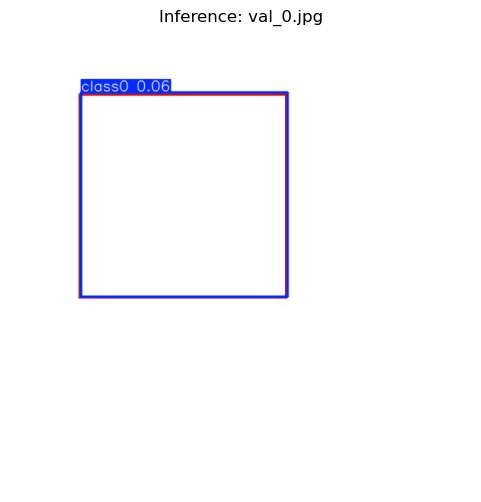

Boxes: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.0478])
data: tensor([[1.3124e+02, 1.4615e+02, 4.6586e+02, 3.1967e+02, 4.7821e-02, 0.0000e+00]])
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([1, 6])
xywh: tensor([[298.5502, 232.9089, 334.6278, 173.5143]])
xywhn: tensor([[0.4665, 0.3639, 0.5229, 0.2711]])
xyxy: tensor([[131.2363, 146.1518, 465.8641, 319.6661]])
xyxyn: tensor([[0.2051, 0.2284, 0.7279, 0.4995]])
xyxy: [[     131.24      146.15      465.86      319.67]]
conf: [   0.047821]
cls : [          0]


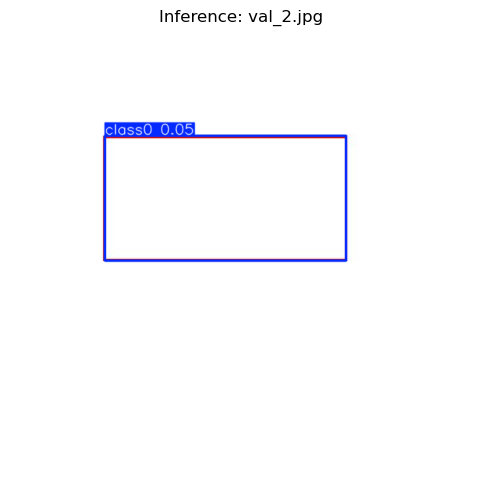

Boxes: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.0147])
data: tensor([[2.0045e+02, 6.6243e+01, 3.1195e+02, 5.3925e+02, 1.4667e-02, 0.0000e+00]])
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([1, 6])
xywh: tensor([[256.1999, 302.7452, 111.5009, 473.0037]])
xywhn: tensor([[0.4003, 0.4730, 0.1742, 0.7391]])
xyxy: tensor([[200.4495,  66.2433, 311.9503, 539.2471]])
xyxyn: tensor([[0.3132, 0.1035, 0.4874, 0.8426]])
xyxy: [[     200.45      66.243      311.95      539.25]]
conf: [   0.014667]
cls : [          0]


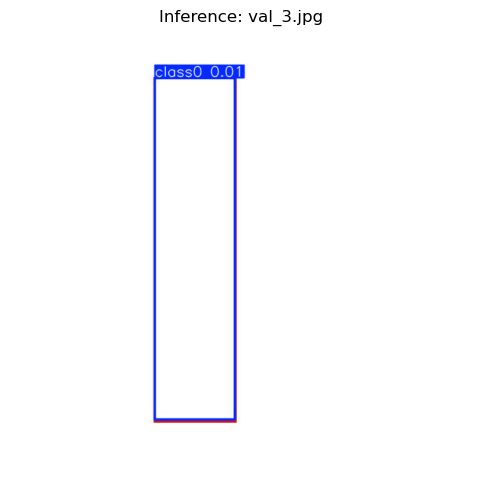

Boxes: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.0302])
data: tensor([[1.9742e+02, 7.5810e+01, 5.3965e+02, 5.0304e+02, 3.0206e-02, 0.0000e+00]])
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([1, 6])
xywh: tensor([[368.5341, 289.4247, 342.2249, 427.2289]])
xywhn: tensor([[0.5758, 0.4522, 0.5347, 0.6675]])
xyxy: tensor([[197.4216,  75.8103, 539.6465, 503.0392]])
xyxyn: tensor([[0.3085, 0.1185, 0.8432, 0.7860]])
xyxy: [[     197.42       75.81      539.65      503.04]]
conf: [   0.030206]
cls : [          0]


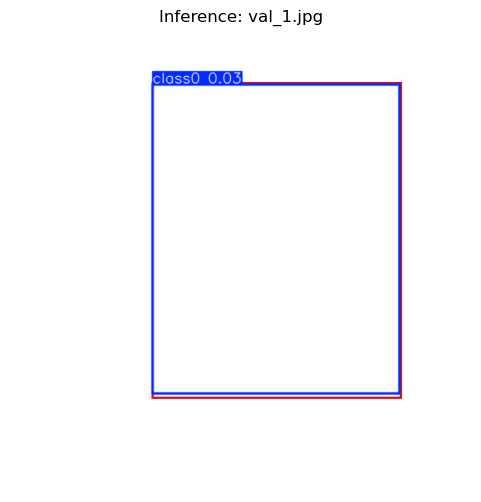

In [25]:
from ultralytics import YOLO
from pathlib import Path
import random
import matplotlib.pyplot as plt
from PIL import Image as PILImage

# 下載並解壓 dataset（只需做一次）
from sagemaker.s3 import S3Downloader
from pathlib import Path
import zipfile

LOCAL_DATA_DIR = Path("dataset_local")
LOCAL_DATA_DIR.mkdir(exist_ok=True)

local_zip = LOCAL_DATA_DIR / DATA_ZIP_FILENAME

# 從 S3 下載你訓練用的 dataset zip
S3Downloader.download(S3_DATA_ZIP, str(LOCAL_DATA_DIR))

# 解壓
with zipfile.ZipFile(local_zip, "r") as z:
    z.extractall(LOCAL_DATA_DIR)

print("Dataset extracted to:", LOCAL_DATA_DIR)



# 推論權重（第 5 格解壓後應該存在）
weights = best_pt  # 由第 5 格定義：out_dir/best.pt
assert Path(weights).exists(), f"best.pt not found: {weights}"

# 嘗試從 artifacts 旁邊找到一批 val images
# 你的 dataset zip 已在訓練容器內解壓；這裡 Notebook 端通常沒有 dataset。
# 因此我們採用兩種策略：
# 1) 若你本機/Notebook 有 dataset（例如你也下載/解壓在 workspace），就用它
# 2) 否則：請你自行指定 VAL_IMAGES_DIR（下面提供範例）

# ====== 你可以在這裡指定 val 影像資料夾（若自動偵測不到）======
VAL_IMAGES_DIR = "dataset_local/mydata/images/val"  # 例如: "mydata/images/val" 或 "/home/ec2-user/SageMaker/mydata/images/val"
# ============================================================

candidates = []

# (A) 若使用者指定
if VAL_IMAGES_DIR:
    p = Path(VAL_IMAGES_DIR)
    if p.exists():
        candidates += list(p.glob("*.jpg")) + list(p.glob("*.png"))

# (B) 嘗試在 Notebook 工作目錄下找常見路徑
common_roots = [
    Path("."),
    Path("data"),
    Path("dataset"),
    Path("mydata"),
    Path("yolo_test_dataset"),
]
for r in common_roots:
    p = r / "mydata" / "images" / "val"
    if p.exists():
        candidates += list(p.glob("*.jpg")) + list(p.glob("*.png"))
    p2 = r / "images" / "val"
    if p2.exists():
        candidates += list(p2.glob("*.jpg")) + list(p2.glob("*.png"))

# 去重
candidates = sorted(set(candidates))

if not candidates:
    raise FileNotFoundError(
        "找不到 val 影像可視覺化推論。"
        "請把 VAL_IMAGES_DIR 設成你的 val 影像資料夾，例如："
        "VAL_IMAGES_DIR = 'mydata/images/val'"
    )

# 抽樣幾張
k = min(6, len(candidates))
sample_imgs = random.sample(candidates, k=k)
print("Using weights:", weights)
print("Visualizing", k, "images:")
for p in sample_imgs:
    print(" -", p)

model = YOLO(str(weights))

# 逐張推論並顯示（Ultralytics 會輸出 results[0].plot() 的 ndarray）
for img_path in sample_imgs:
    results = model.predict(source=str(img_path), imgsz=IMGSZ, conf=0.01, verbose=False)
    r = results[0]
    print("Boxes:", r.boxes)
    if r.boxes is not None and len(r.boxes) > 0:
        print("xyxy:", r.boxes.xyxy.cpu().numpy())
        print("conf:", r.boxes.conf.cpu().numpy())
        print("cls :", r.boxes.cls.cpu().numpy())
    else:
        print("❌ No detections")
    plotted = results[0].plot()  # numpy array (BGR)
    # BGR -> RGB for matplotlib
    plotted_rgb = plotted[..., ::-1]

    plt.figure(figsize=(6,6))
    plt.imshow(plotted_rgb)
    plt.axis("off")
    plt.title(f"Inference: {Path(img_path).name}")
    plt.show()


In [21]:
!pip install -U ultralytics opencv-python

  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 154.2 MB/s  0:00:00m0:00:0100:01
Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.4/802.4 kB 90.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 MB 169.8 MB/s  0:00:00m0:00:01
  Attempting uninstall: numpy━━━━━━━━━━━━━━━━━━━ 0/6 [polars-runtime-32]
    Found existing installation: numpy 1.26.4 0/6 [polars-runtime-32]
    Uninstalling numpy-1.26.4:90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/6 [numpy]
      Successfully uninstalled numpy-1.26.4━━━━━━━━━━━━━━━━━━━ 1/6 [numpy]
  Attempting uninstall: opencv-python90m━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/6 [polars]
    Found existing installation: opencv-python 4.11.0.86━━━━━━ 2/6 [polars]
    Uninstalling opencv